<div id='eda'/>
# Exploratory Data Analysis (EDA)
## Import US dataset

In [24]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.5,rc={'figure.figsize':(11.7,8.27)})

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime as dt

# Import US Data
GBvideos = pd.read_csv('./data/GBvideos.csv')
GB_videos_categories = pd.read_json('./data/GB_category_id.json')

# Map Category IDs using the supporting file: US_category_id.json
categories = {int(category['id']): category['snippet']['title'] for category in GB_videos_categories['items']}

## Quick Summaries

In [25]:
import json
f = open("./data/GB_category_id.json")
data = f.read()
f.close()
out = json.loads(data)
categories = pd.DataFrame([
    {'category_id':x['id'],
     'category':x['snippet']['title'],
     'assignable':x['snippet']['assignable']
    } for x in out['items']
])
categories['category_id'] = categories['category_id'].astype(int)

GBvideos['category_id'] = GBvideos['category_id'].astype(int)
GBvideos = GBvideos.merge(categories, on='category_id')
GBvideos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'category', 'assignable'],
      dtype='object')

<div id="datapre" />
# Data preprocessing
### Date Variable Transformations
#### Trending Date

In [26]:
# Transform trending_date to datetime date format
GBvideos['trending_date'] = pd.to_datetime(GBvideos['trending_date'], format='%y.%d.%m').dt.date
GBvideos.trending_date.value_counts().sort_index(inplace=True)

In [27]:
# Dataset is sorted by trending_date
pd.Index(GBvideos.trending_date).is_monotonic

False

#### Publish Time

In [28]:
# Transforming publish_time to datetime
publish_time = pd.to_datetime(GBvideos.publish_time, format='%Y-%m-%dT%H:%M:%S.%fZ')

# Create Variable publish_date
GBvideos['publish_date'] = publish_time.dt.date

# Drop publish_time
GBvideos.drop('publish_time',axis=1,inplace=True)

#### Days to Trending

In [29]:
# Create New Variable Counting Days to Achieving Trending Status
GBvideos['days_to_trending'] = (GBvideos.trending_date - GBvideos.publish_date).dt.days
GBvideos.days_to_trending.describe(percentiles=[.05,.25,.5,.75,.95])

count    38826.000000
mean        36.819013
std        241.742445
min          0.000000
5%           2.000000
25%          5.000000
50%         10.000000
75%         18.000000
95%         33.000000
max       3990.000000
Name: days_to_trending, dtype: float64

<div id='reindex' />
### Create Meaningful Data Frame Index

In [30]:
GBvideos.set_index(['trending_date','video_id'],inplace=True)

<div id='dispct'/>
### Dislike percentage

In [31]:
GBvideos['dislike_percentage'] = GBvideos['dislikes'] / (GBvideos['dislikes'] + GBvideos['likes'])

<div id='cleanup'/>
### Data Clean Up
#### Drop Unreliable Observations

In [32]:
GBvideos = GBvideos[~GBvideos.video_error_or_removed]

<div id="vidlevel" />
## New Data Frame: Video Level Stats

In [36]:
# Video Level Stats Using First Occurence Values
video_level = GBvideos.groupby(level=1).first()
video_level['freq'] = GBvideos['title'].groupby(level=1).count()
#video_level['category'] = [categories[cid] for cid in video_level.category_id]
video_level = video_level.drop(['category_id'], axis=1)
video_level.sort_values(by=['views'],ascending=False,inplace=True)
video_level['views_ratio'] = GBvideos['views'].groupby(level=1).last() / video_level.views
views_min_dt = pd.Series([t[0] for t in GBvideos['views'].groupby(level=1).idxmin()],index=video_level.index)
video_level['views_min_dt'] = views_min_dt

title  \
video_id                                                         
TyHvyGVs42U          Luis Fonsi, Demi Lovato - Échame La Culpa   
zEf423kYfqk  Becky G, Natti Natasha - Sin Pijama (Official ...   
WtE011iVx1Q  Sebastián Yatra - Por Perro ft. Luis Figueroa,...   
Ck4xHocysLw           Ozuna - Única (Video Oficial) 🐻 A U R A   
7C2z4GqqS5E                BTS (방탄소년단) 'FAKE LOVE' Official MV   

                  channel_title  \
video_id                          
TyHvyGVs42U       LuisFonsiVEVO   
zEf423kYfqk          BeckyGVEVO   
WtE011iVx1Q  SebastianYatraVEVO   
Ck4xHocysLw               Ozuna   
7C2z4GqqS5E             ibighit   

                                                          tags      views  \
video_id                                                                    
TyHvyGVs42U  Luis|"Fonsi"|"Demi"|"Lovato"|"Échame"|"La"|"Cu...  143408235   
zEf423kYfqk  Becky G|"Natti Natasha"|"Natti Natasha Music"|...   88568646   
WtE011iVx1Q  Sebastián|"Yatra"|"Por"|"Perro"|"Andres"|"Saav...   47669287   
Ck4xHocysLw  Ozuna|"Reggaeton"|"Odisea"|"Odisea The Album"|...   42923278   
7C2z4GqqS5E          BIGHIT|"빅히트"|"방탄소년단"|"BTS"|"BANGTAN"|"방탄"   39349927   

               likes  dislikes  comment_count  \
video_id                                        
TyHvyGVs42U  2686169    137938         144217   
zEf423kYfqk  1185357     99361          70242   
WtE011iVx1Q   396337     15105          15955   
Ck4xHocysLw   495422     17706          18091   
7C2z4GqqS5E  3880074     72707         692311   

                                             thumbnail_link  \
video_id                                                      
TyHvyGVs42U  https://i.ytimg.com/vi/TyHvyGVs42U/default.jpg   
zEf423kYfqk  https://i.ytimg.com/vi/zEf423kYfqk/default.jpg   
WtE011iVx1Q  https://i.ytimg.com/vi/WtE011iVx1Q/default.jpg   
Ck4xHocysLw  https://i.ytimg.com/vi/Ck4xHocysLw/default.jpg   
7C2z4GqqS5E  https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg   

             comments_disabled  ratings_disabled  video_error_or_removed  \
video_id                                                                   
TyHvyGVs42U              False             False                   False   
zEf423kYfqk              False             False                   False   
WtE011iVx1Q              False             False                   False   
Ck4xHocysLw              False             False                   False   
7C2z4GqqS5E              False             False                   False   

                                                   description category  \
video_id                                                                  
TyHvyGVs42U  “Échame La Culpa” disponible ya en todas las p...    Music   
zEf423kYfqk  Becky G & Natti Natasha – “Sin Pijama”NUEVO SE...    Music   
WtE011iVx1Q  Music video by Sebastián Yatra performing Por ...    Music   
Ck4xHocysLw  DESCARGA Odisea Aqui: http://apple.co/2vX00sT\...    Music   
7C2z4GqqS5E  BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...    Music   

             assignable publish_date  days_to_trending  dislike_percentage  \
video_id                                                                     
TyHvyGVs42U        True   2017-11-17                14            0.048843   
zEf423kYfqk        True   2018-04-20                16            0.077341   
WtE011iVx1Q        True   2018-03-30                15            0.036712   
Ck4xHocysLw        True   2018-04-26                 6            0.034506   
7C2z4GqqS5E        True   2018-05-18                 1            0.018394   

             freq  views_ratio views_min_dt  
video_id                                     
TyHvyGVs42U     1     1.000000   2017-12-25  
zEf423kYfqk    21     2.267876   2017-12-31  
WtE011iVx1Q    22     1.947563   2018-02-14  
Ck4xHocysLw    31     3.193643   2017-11-29  
7C2z4GqqS5E    14     3.126077   2018-02-24

In [37]:
video_level.describe(percentiles=[.05,.25,.5,.75,.95])

views         likes       dislikes  comment_count  \
count  3.261000e+03  3.261000e+03    3261.000000    3261.000000   
mean   1.292594e+06  5.403225e+04    2308.261576    6278.313707   
std    4.389726e+06  1.688089e+05   16606.457055   27752.690707   
min    8.510000e+02  0.000000e+00       0.000000       0.000000   
5%     2.449400e+04  3.020000e+02      12.000000      38.000000   
25%    8.894900e+04  2.514000e+03      73.000000     324.000000   
50%    2.794470e+05  8.357000e+03     250.000000    1025.000000   
75%    9.653280e+05  3.542700e+04    1017.000000    3660.000000   
95%    5.331049e+06  2.372870e+05    8233.000000   22541.000000   
max    1.434082e+08  3.880074e+06  629123.000000  733371.000000   

       days_to_trending  dislike_percentage         freq  views_ratio  
count       3261.000000         3248.000000  3261.000000  3261.000000  
mean          36.970868            0.057425    11.885005     3.693787  
std          273.927213            0.099657     8.727185     8.376222  
min            0.000000            0.000000     1.000000     0.794479  
5%             1.000000            0.004769     1.000000     1.000000  
25%            1.000000            0.013039     6.000000     1.227002  
50%            2.000000            0.025954    10.000000     1.783717  
75%            4.000000            0.056341    15.000000     3.039564  
95%           16.000000            0.213995    31.000000    12.320767  
max         3982.000000            0.965436    38.000000   169.468721

## Video Category Distribution

### Days to Trending Status

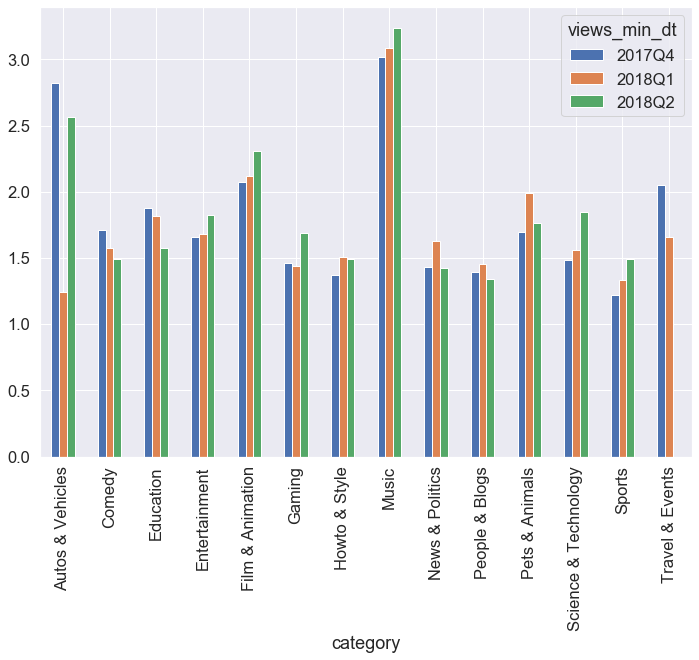

In [38]:
video_level['views_min_dt'] = video_level.views_min_dt.dt.to_period('Q')
tmp = video_level.groupby(['category','views_min_dt']).views_ratio.median()
_ = tmp.unstack().plot(kind='bar')

In [39]:
tmp = video_level[(video_level.views_ratio < 10) & (video_level.freq > 1) & (video_level.views_ratio > .8)].dropna().sort_values(by='views_ratio')
cat_ratio_median = tmp.groupby('category')['views_ratio'].median()
tmp = tmp.merge(cat_ratio_median.rename('cat_ratio_median').to_frame(), left_on='category',right_index=True)

y = np.log(tmp.views_ratio)
print('y')
print(y.describe(percentiles=[.05,.25,.5,.75,.95]))
X = tmp[['views','likes','dislikes','comment_count','dislike_percentage','days_to_trending','cat_ratio_median']]


tmp_log = np.log(tmp[['views','likes','dislikes','comment_count','dislike_percentage','days_to_trending','cat_ratio_median','views_ratio']]+1)
X_reg = tmp_log[['views','likes','dislikes','comment_count','dislike_percentage','days_to_trending','cat_ratio_median']]
y_reg = tmp_log.views_ratio
print('y_reg')
print(y_reg.describe(percentiles=[.05,.25,.5,.75,.95]))

y
count    2763.000000
mean        0.702762
std         0.547456
min        -0.209408
5%          0.042263
25%         0.257732
50%         0.584465
75%         1.029457
95%         1.837817
max         2.301969
Name: views_ratio, dtype: float64
y_reg
count    2763.000000
mean        1.135942
std         0.388770
min         0.593915
5%          0.714502
25%         0.830294
50%         1.027485
75%         1.334881
95%         1.985516
max         2.397335
Name: views_ratio, dtype: float64


In [40]:
_ = sns.pairplot(pd.concat((X,y.rename('y')),axis=1).sample(500)) # Notice Sampling: EDA Principle 3

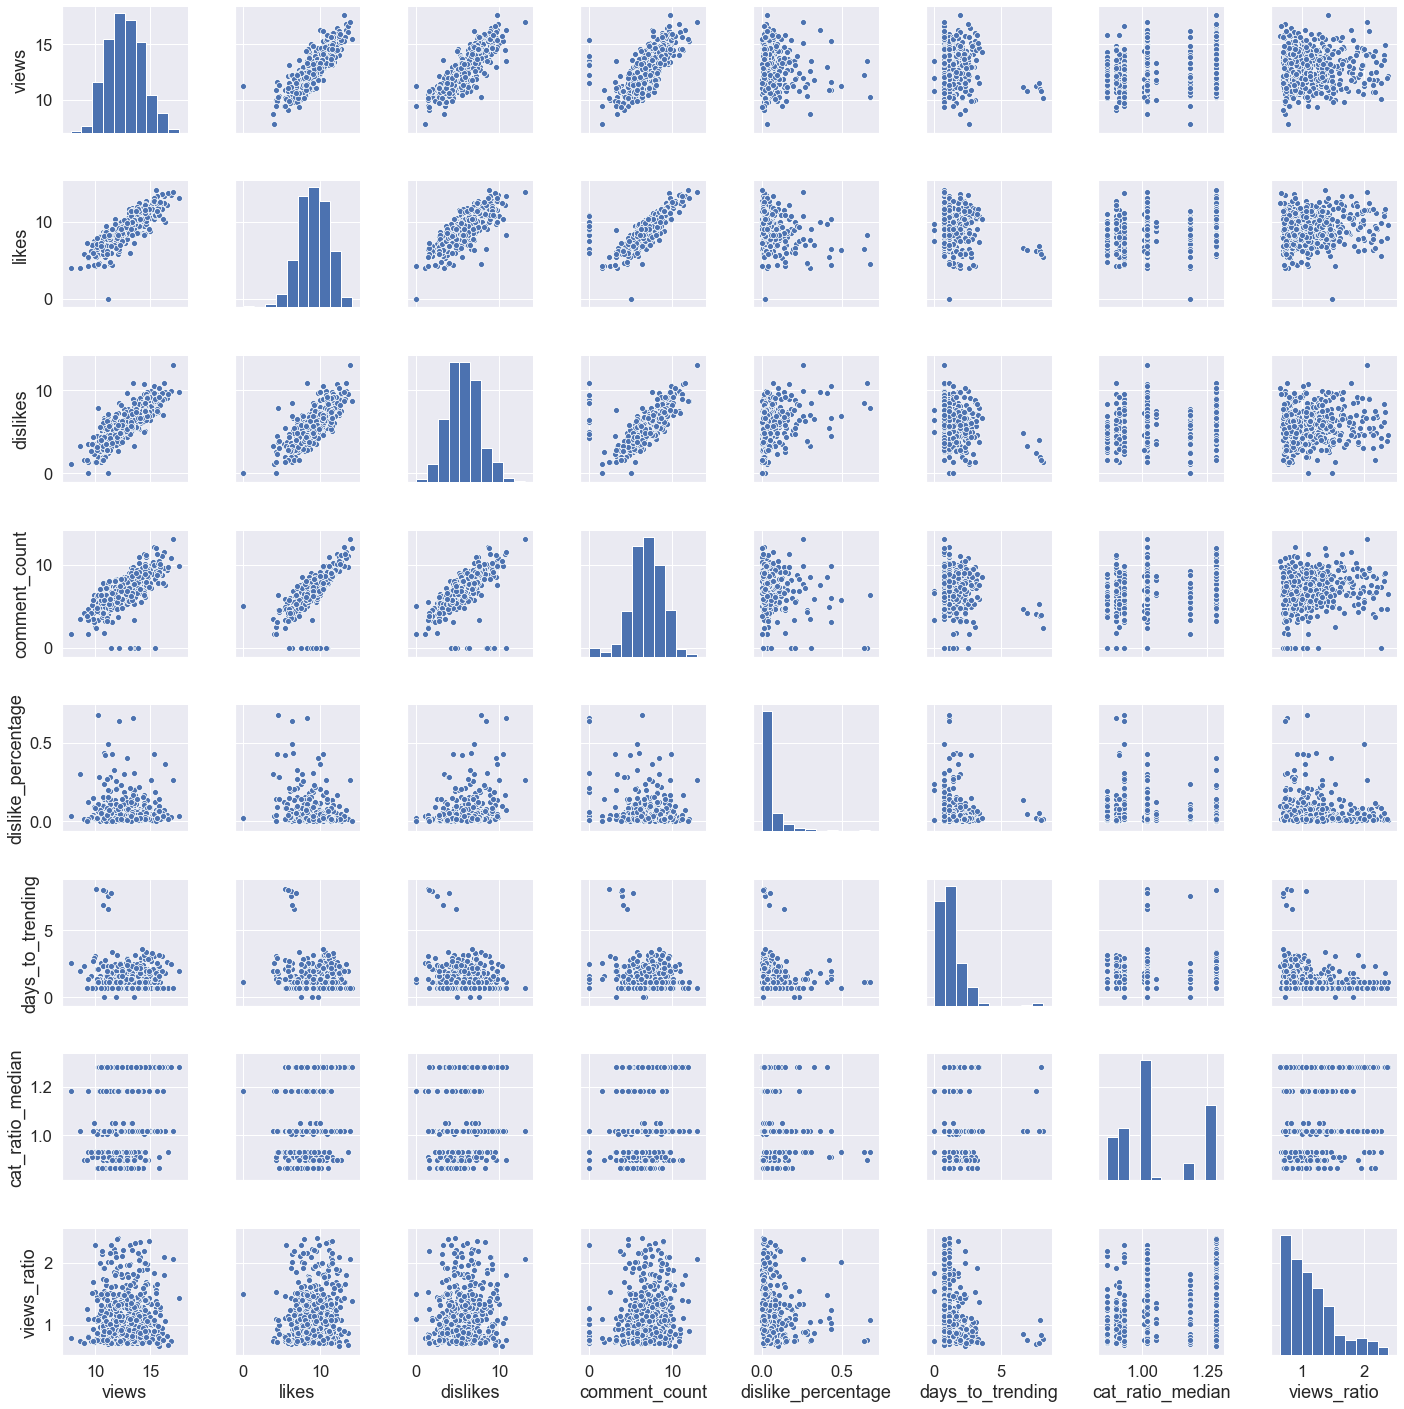

In [41]:
_ = sns.pairplot(tmp_log.sample(500))  # Notice Sampling: EDA Principle 3

In [42]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lars, Ridge


regr_1 = DecisionTreeRegressor(max_depth=2,min_samples_leaf=.01)
regr_2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=.01)
regr_ols = LinearRegression()
regr_lrs = Lars()
regr_rdg = Ridge (alpha = .5)

regr_1.fit(X, y)
regr_2.fit(X, y)
regr_ols.fit(X_reg, y_reg)
regr_lrs.fit(X_reg, y_reg)
regr_rdg.fit(X_reg, y_reg)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)
y_ols = regr_ols.predict(X_reg)
y_lrs = regr_lrs.predict(X_reg)
y_rdg = regr_rdg.predict(X_reg)

print((y_1 - y).describe(percentiles=[.05,.25,.5,.75,.95]))
print('Regression Tree 1: R-sq = {:.2%}'.format(metrics.r2_score(y,y_1)))


print((y_ols - y).describe(percentiles=[.05,.25,.5,.75,.95]))
print('OLS: R-sq = {:.2%}'.format(metrics.r2_score(y_reg,y_ols)))



print((y_lrs - y).describe(percentiles=[.05,.25,.5,.75,.95]))
print('LARS: R-sq = {:.2%}'.format(metrics.r2_score(y_reg,y_lrs)))



print((y_rdg - y).describe(percentiles=[.05,.25,.5,.75,.95]))
print('Ridge Regression: R-sq = {:.2%}'.format(metrics.r2_score(y_reg,y_rdg)))

count    2.763000e+03
mean    -3.857452e-16
std      4.592457e-01
min     -1.843326e+00
5%      -9.066185e-01
25%     -2.566384e-01
50%      9.034653e-02
75%      3.269836e-01
95%      6.215628e-01
max      1.240143e+00
Name: views_ratio, dtype: float64
Regression Tree 1: R-sq = 29.63%
count    2763.000000
mean        0.433180
std         0.477212
min        -1.258418
5%         -0.546279
25%         0.169548
50%         0.534829
75%         0.803758
95%         1.013933
max         1.391970
Name: views_ratio, dtype: float64
OLS: R-sq = 25.12%
count    2763.000000
mean        0.433180
std         0.477212
min        -1.258418
5%         -0.546279
25%         0.169548
50%         0.534829
75%         0.803758
95%         1.013933
max         1.391970
Name: views_ratio, dtype: float64
LARS: R-sq = 25.12%
count    2763.000000
mean        0.433180
std         0.477354
min        -1.259082
5%         -0.546018
25%         0.169310
50%         0.536119
75%         0.804083
95%         1.0123

In [55]:
import graphviz 
dot_data = tree.export_graphviz(
    regr_1, out_file=None, feature_names=X.columns,
    proportion=True, impurity=False,filled=True, rounded=True) 
graph = graphviz.Source(dot_data)
graph.render("value")
graph

In [56]:
# Alternative Regression Tree with Bigger Depth
# Better Performance but More Difficult to Understand
print((y_2 - y).describe())
print('R-sq = {:.2%}'.format(metrics.r2_score(y,y_2)))
y_2_unique = pd.Series(pd.unique(y_2))
#print(pd.concat([y_2_unique.rename('y'),np.exp(y_2_unique).rename('exp(y)')],axis=1))
dot_data = tree.export_graphviz(
    regr_2, out_file=None, feature_names=X.columns,class_names=["Trending", "Not Trending"],
    proportion=True, impurity=False,filled=True, rounded=True) 
graph = graphviz.Source(dot_data)
graph.render("value")
graph

count    2.763000e+03
mean    -7.200578e-17
std      4.247373e-01
min     -1.856908e+00
25%     -2.310032e-01
50%      9.455360e-02
75%      2.667406e-01
max      1.337483e+00
Name: views_ratio, dtype: float64
R-sq = 39.81%


#### RESULT
The first regression tree, regr_1, captures the main result. The key variable is days_to_treding, the lower it is the higher the expected views ratio (increase). For instant hits (days_to_trending <= 1) category is an additional predictor of future success, namely if a video belongs to the categories: "Film & Animation" or "Music."

In [57]:
days_to_trending_cat = pd.cut(video_level.days_to_trending,[0,1,2,3,np.inf])
ax = video_level.groupby(days_to_trending_cat)['views_ratio'].median().plot(kind='bar')
_ = ax.set(ylabel="Median Views Ratio",xlabel="Days to Trending Groups")

In [58]:
# Categories with High Median Views Ratio
cat_ratio_median[cat_ratio_median > 1.837]

category
Education           1.861516
Film & Animation    2.265657
Music               2.610127
Name: views_ratio, dtype: float64